---
title: "Audio Classification using Transformers"
description: "Attention is all you need!! In this blog, we implement music genre classification model using Transformers"
date: "2025-01-26"
categories:
  - Transformers
  - deep learning
  - fine-tuning
image: "images/transformers.png"
---

# Audio Classification using Transformers

## Attention is all you need!!
Transformers based models have been at the forefront of the Artificial Intelligence, primarily due to huge success in natural language processing (NLP) tasks. Transformers work so well due to the mechanism of self attention which helps the model to learn long range dependencies. However, their applications extend well beyond text. In fact, the attention mechanism can be applied and work exceptionally well on images, audio and video data as well.

In this tutorial, we will understand the applications of transformers for audio classification task. We will take a pretrained transformer based model from huggingface and finetune it for the purpose of music genre classification.

## Import Packages
For this tutorial, we need to install pytorch, datasets, transformers and evaluate packages. We will use Weights and Biases for logging.

In [1]:
# !pip -q install datasets==3.2.0
# !pip -q install transformers==4.8.1
# !pip -q install evaluate==0.4.3
# !pip -q install torch==2.5.1

In [ ]:
from datasets import load_dataset, Audio
import evaluate
import IPython
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import wandb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import userdata
wandb.login(key=userdata.get('WB_TOKEN'))

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

## Load and Inspect Dataset
- We will use `marsyas/gtzan` dataset from huggingface. The dataset consists of 1,000 audio tracks, each of 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22,050Hz Mono 16-bit audio files in WAV format. The genres are: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, and rock.
- Each example contains audio in the form of array. The elements of the array represent amplitude of the audio signals at various timestamps. Since, each audio has sampling rate of 22050Hz, the array contains 22050 elements for each second of the audio.
- We can also listen to some of the audio clips using Audio class from IPython package.

In [ ]:
data = load_dataset('marsyas/gtzan', trust_remote_code=True)

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [ ]:
data['train'][0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav',
  'array': array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
         -0.06106567, -0.06417847]),
  'sampling_rate': 22050},
 'genre': 0}

In [ ]:
data['train'][0]['audio']['array']

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847])

In [ ]:
len(data['train'][0]['audio']['array'])

661794

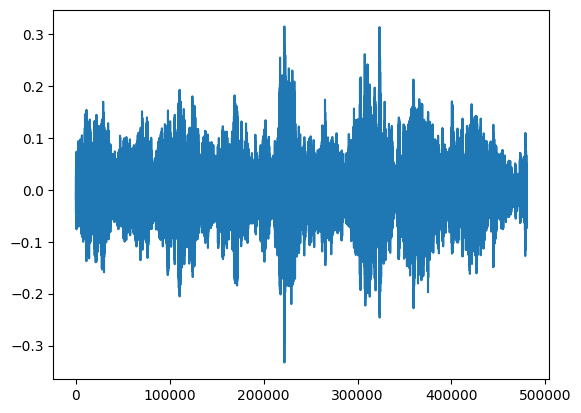

In [ ]:
plt.plot(data['train'][100]['audio']['array'])

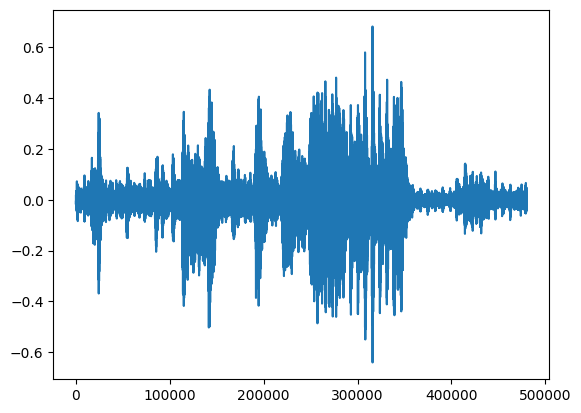

In [ ]:
plt.plot(data['train'][500]['audio']['array'])

In [ ]:
print('Genre is: {}'.format(id2label[data['train'][0]['genre']]))
IPython.display.Audio(data['train'][0]['audio']['array'], 
                      rate=data['train'][0]['audio']['sampling_rate'])

Genre is: blues


In [ ]:
print('Genre is: {}'.format(id2label[data['train'][100]['genre']]))
IPython.display.Audio(data['train'][1]['audio']['array'], 
                      rate=data['train'][0]['audio']['sampling_rate'])

Genre is: classical


In [ ]:
print('Genre is: {}'.format(id2label[data['train'][500]['genre']]))
IPython.display.Audio(data['train'][1]['audio']['array'], 
                      rate=data['train'][0]['audio']['sampling_rate'])

Genre is: jazz


In [ ]:
features = data['train'].features
features

{'file': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'genre': ClassLabel(names=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], id=None)}

In [ ]:
label_names = features['genre'].names
label_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
id2label = {id:label for id, label in enumerate(label_names)}
id2label

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [ ]:
label2id = {v:k for k, v in id2label.items()}
label2id

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

## Load Pretrained Model
- For this audio classification task, we will use `facebook/wav2vec2-base` model from Huggingface. This is a 94 million parameter model and is trained on 53K hours of audio data.
- Because of extensive pre-training, the model has quite a lot understanding about the audio features making it quite suitable for various audio finetuning tasks.
- First, we load the feature extractor of the model using `AutoFeatureExtractor.from_pretrained` class. The extractor to audio transformers is what tokenizer is to text transformers. They provide quite convinient functionality to process the input data and make it suitable for feeding it to the model.
- Sampling rate of feature extractor (and hence the model) is 16,000 Hz. Therefore, we need to change the sampling rate of data from 22,500 Hz to 16,000 Hz using `cast_colum` method.
- After that, we use `preprocess_function` to apply transformation of feature extractor to all examples in training data. We use max_length of 30*16000 as we have audio clips of 30 seconds and sampling rate is 16,000 Hz.
- We load the model using `AutoModelForAudioClassification.from_pretrained` method. The pretrained model has 256 neurons in the last layer. Therefore, we need to specify num_labels, labe2id and id2label while loading the model. This changes the last layer of the model and newly initializes it. Because of this, the loaded model will have close to random performance on the audio classification task and fine-tuning needs to be performed before using it.

In [ ]:
model_name = 'facebook/wav2vec2-base'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name,
                                                         return_tensors='pt',
                                                         do_normalize=True,
                                                         return_attention_mask=True)

In [ ]:
feature_extractor.sampling_rate

16000

In [ ]:
data = data.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
data['train'][0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00000.wav',
  'array': array([ 0.00766408,  0.01497506, -0.00178931, ..., -0.05508532,
         -0.06770003,  0.        ]),
  'sampling_rate': 16000},
 'genre': 0}

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, 
        padding=True, truncation=True,
        max_length=30*16000
    )
    return inputs

In [ ]:
encoded_dataset = data.map(preprocess_function, remove_columns=["audio"], batched=True)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'genre', 'input_values', 'attention_mask'],
        num_rows: 999
    })
})

In [ ]:
split_dataset = encoded_dataset['train'].train_test_split(test_size=0.2)

In [ ]:
train_dataset = split_dataset['train']
train_dataset

Dataset({
    features: ['file', 'genre', 'input_values', 'attention_mask'],
    num_rows: 799
})

In [ ]:
eval_dataset = split_dataset['test']
eval_dataset

Dataset({
    features: ['file', 'genre', 'input_values', 'attention_mask'],
    num_rows: 200
})

In [ ]:
num_labels = 10
model = AutoModelForAudioClassification.from_pretrained(model_name,
                                                        num_labels=num_labels,
                                                        label2id=label2id,
                                                        id2label=id2label)

In [ ]:
total_params = 0
for param in model.parameters():
    total_params = total_params + param.numel()
total_params / 1e+06

94.571146

In [ ]:
train_dataset

Dataset({
    features: ['file', 'genre', 'input_values', 'attention_mask'],
    num_rows: 799
})

In [ ]:
train_dataset = train_dataset.rename_column("genre", "label")
eval_dataset = eval_dataset.rename_column("genre", "label")

## Finetune / Train the Model
- We specify training arguements using `TrainingArguments` class from transformers library. We will train the model for 10 epochs and use small batch size of 8 due to resource constraints.
- After that, we create a helper function to calculate accuracy using evaluate package.
- Training of the model is quite easy with `Trainer` class from transformers library.
- We can see that after 10 epochs, we achieve accuracy of 83% on evaluation dataset. The training loss is 0.18 and validatio loss is 0.67. This indicates that the model has overfit the data. This was kind of expected because of small size of the dataset and huge pre-trained model size.
- However, accuracy of 83% after training for only 10 epochs is quite good.

In [ ]:
model_name_1 = model_name.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 10

training_args = TrainingArguments(
    f"{model_name_1}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
)

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


TrainOutput(global_step=1000, training_loss=0.926927893102169, metrics={'train_runtime': 8447.1145, 'train_samples_per_second': 0.946, 'train_steps_per_second': 0.118, 'total_flos': 2.1761955548352e+18, 'train_loss': 0.926927893102169, 'epoch': 10.0})

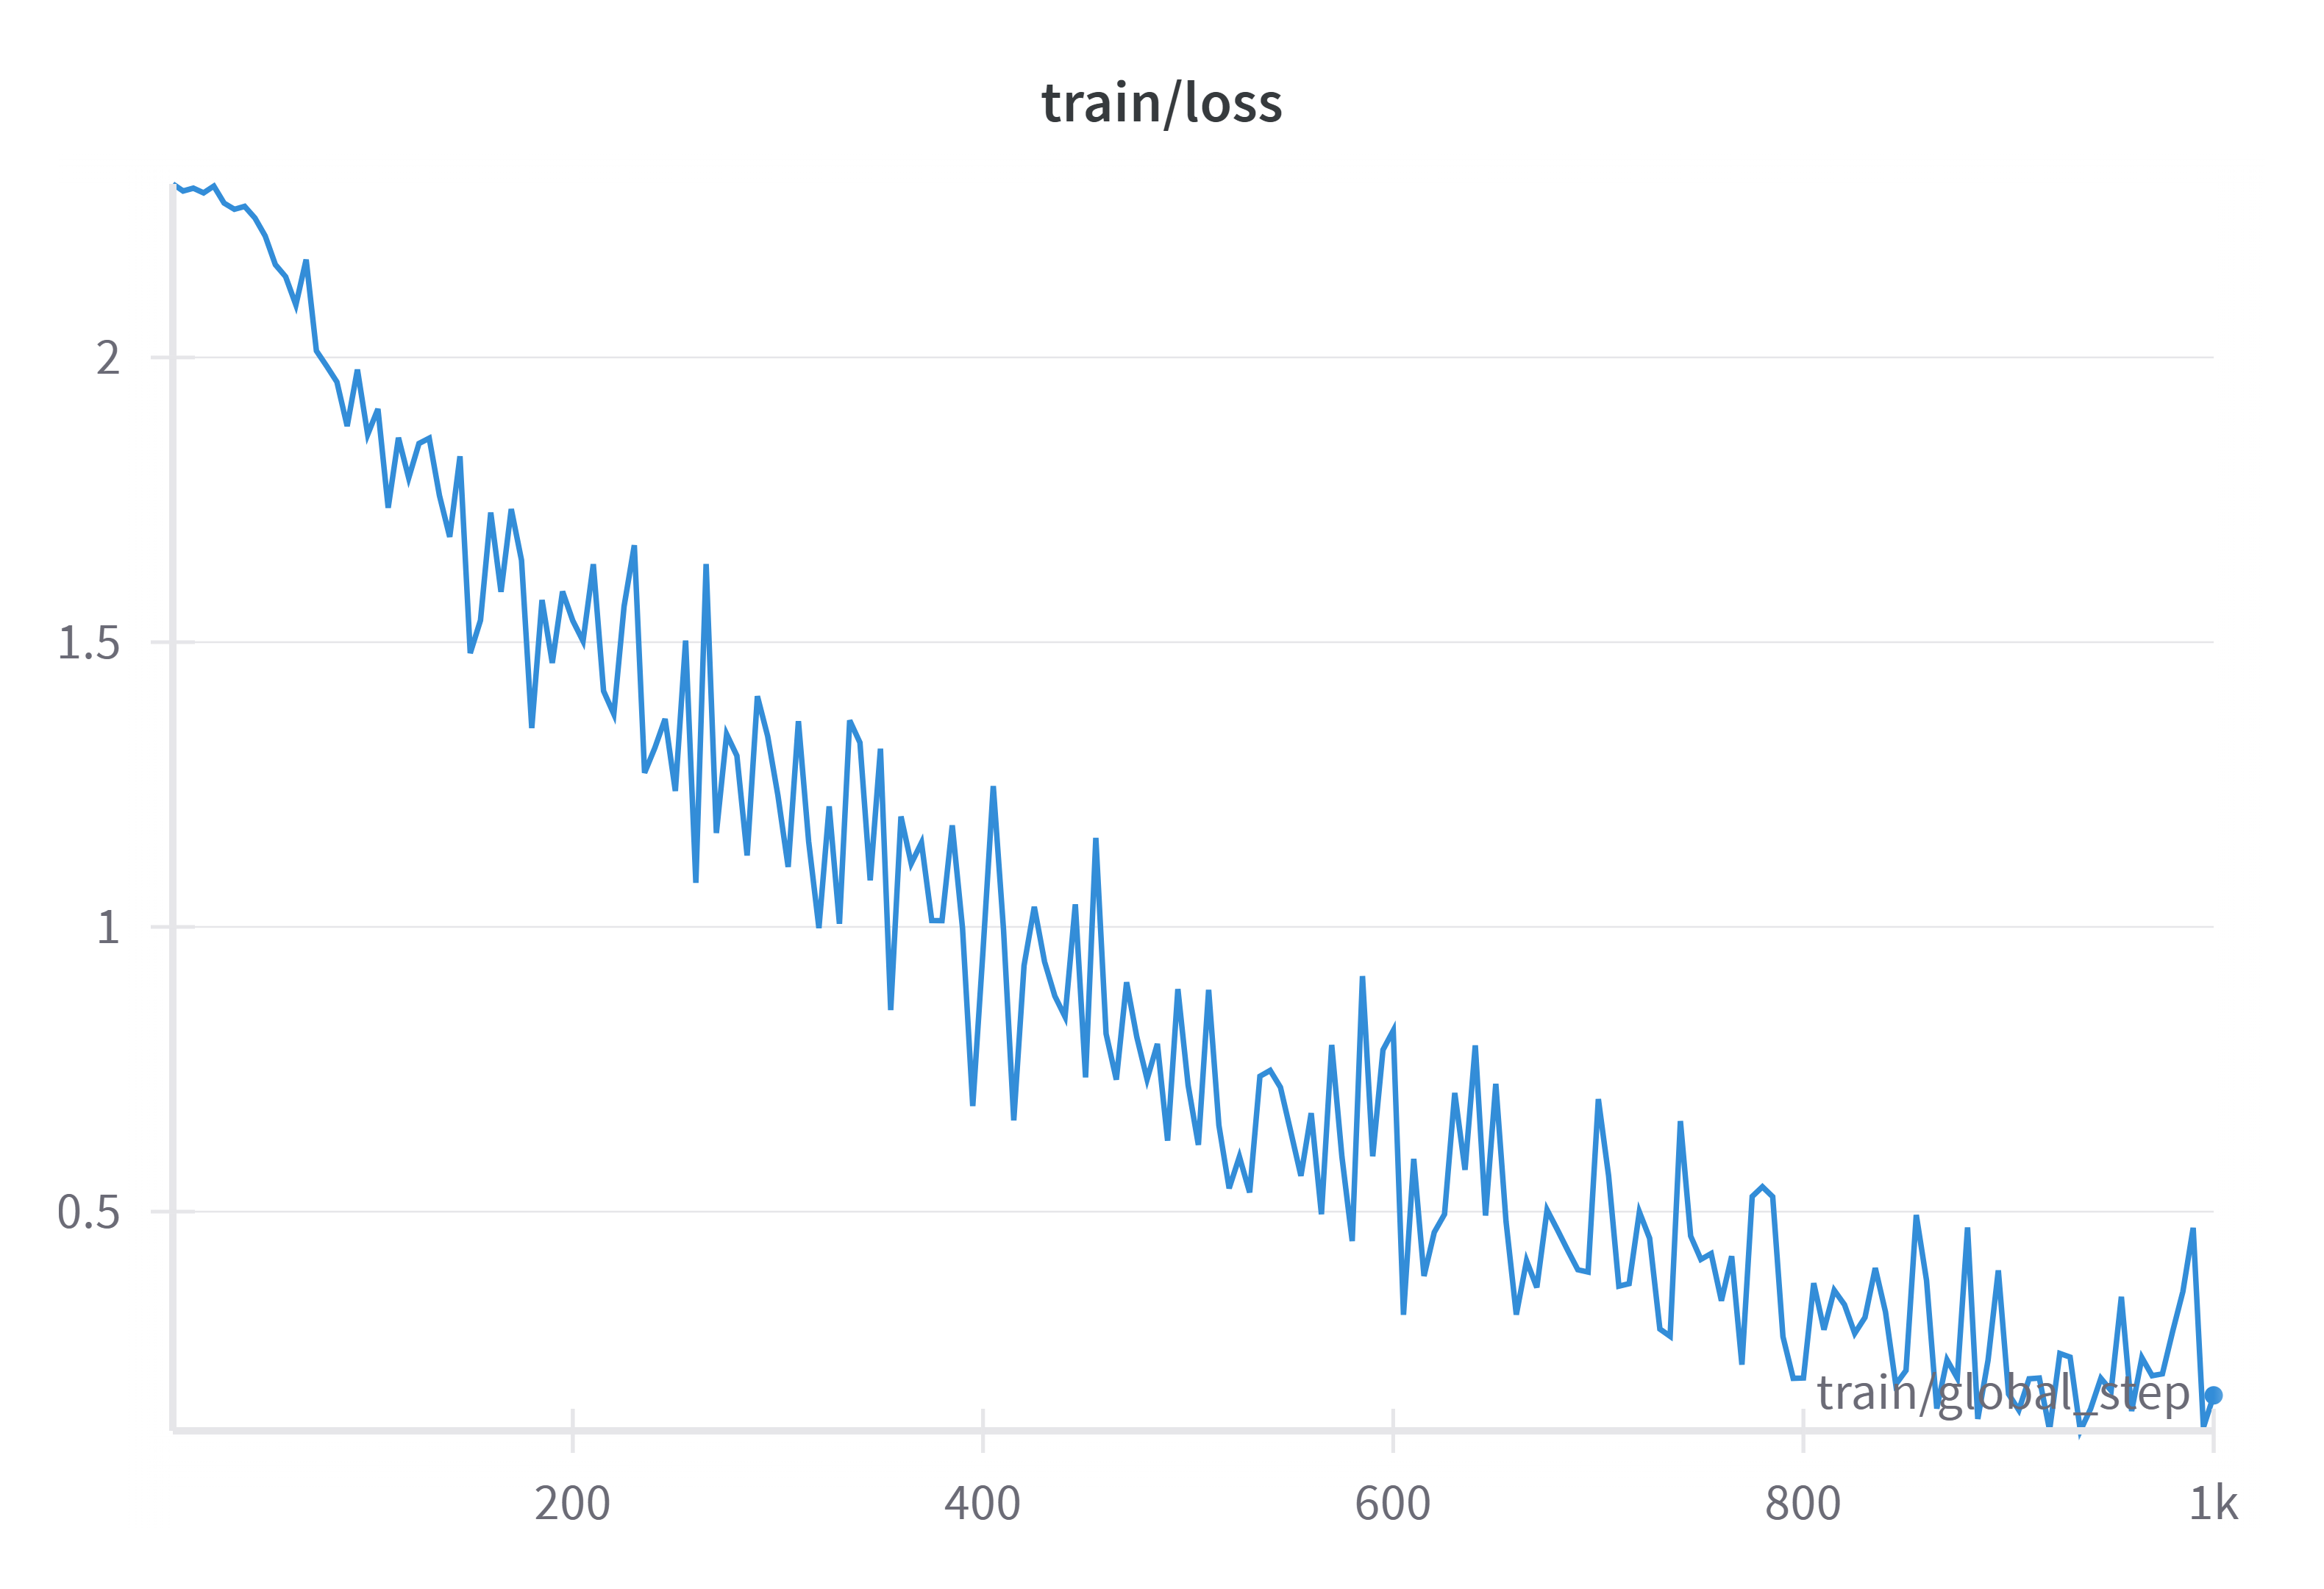

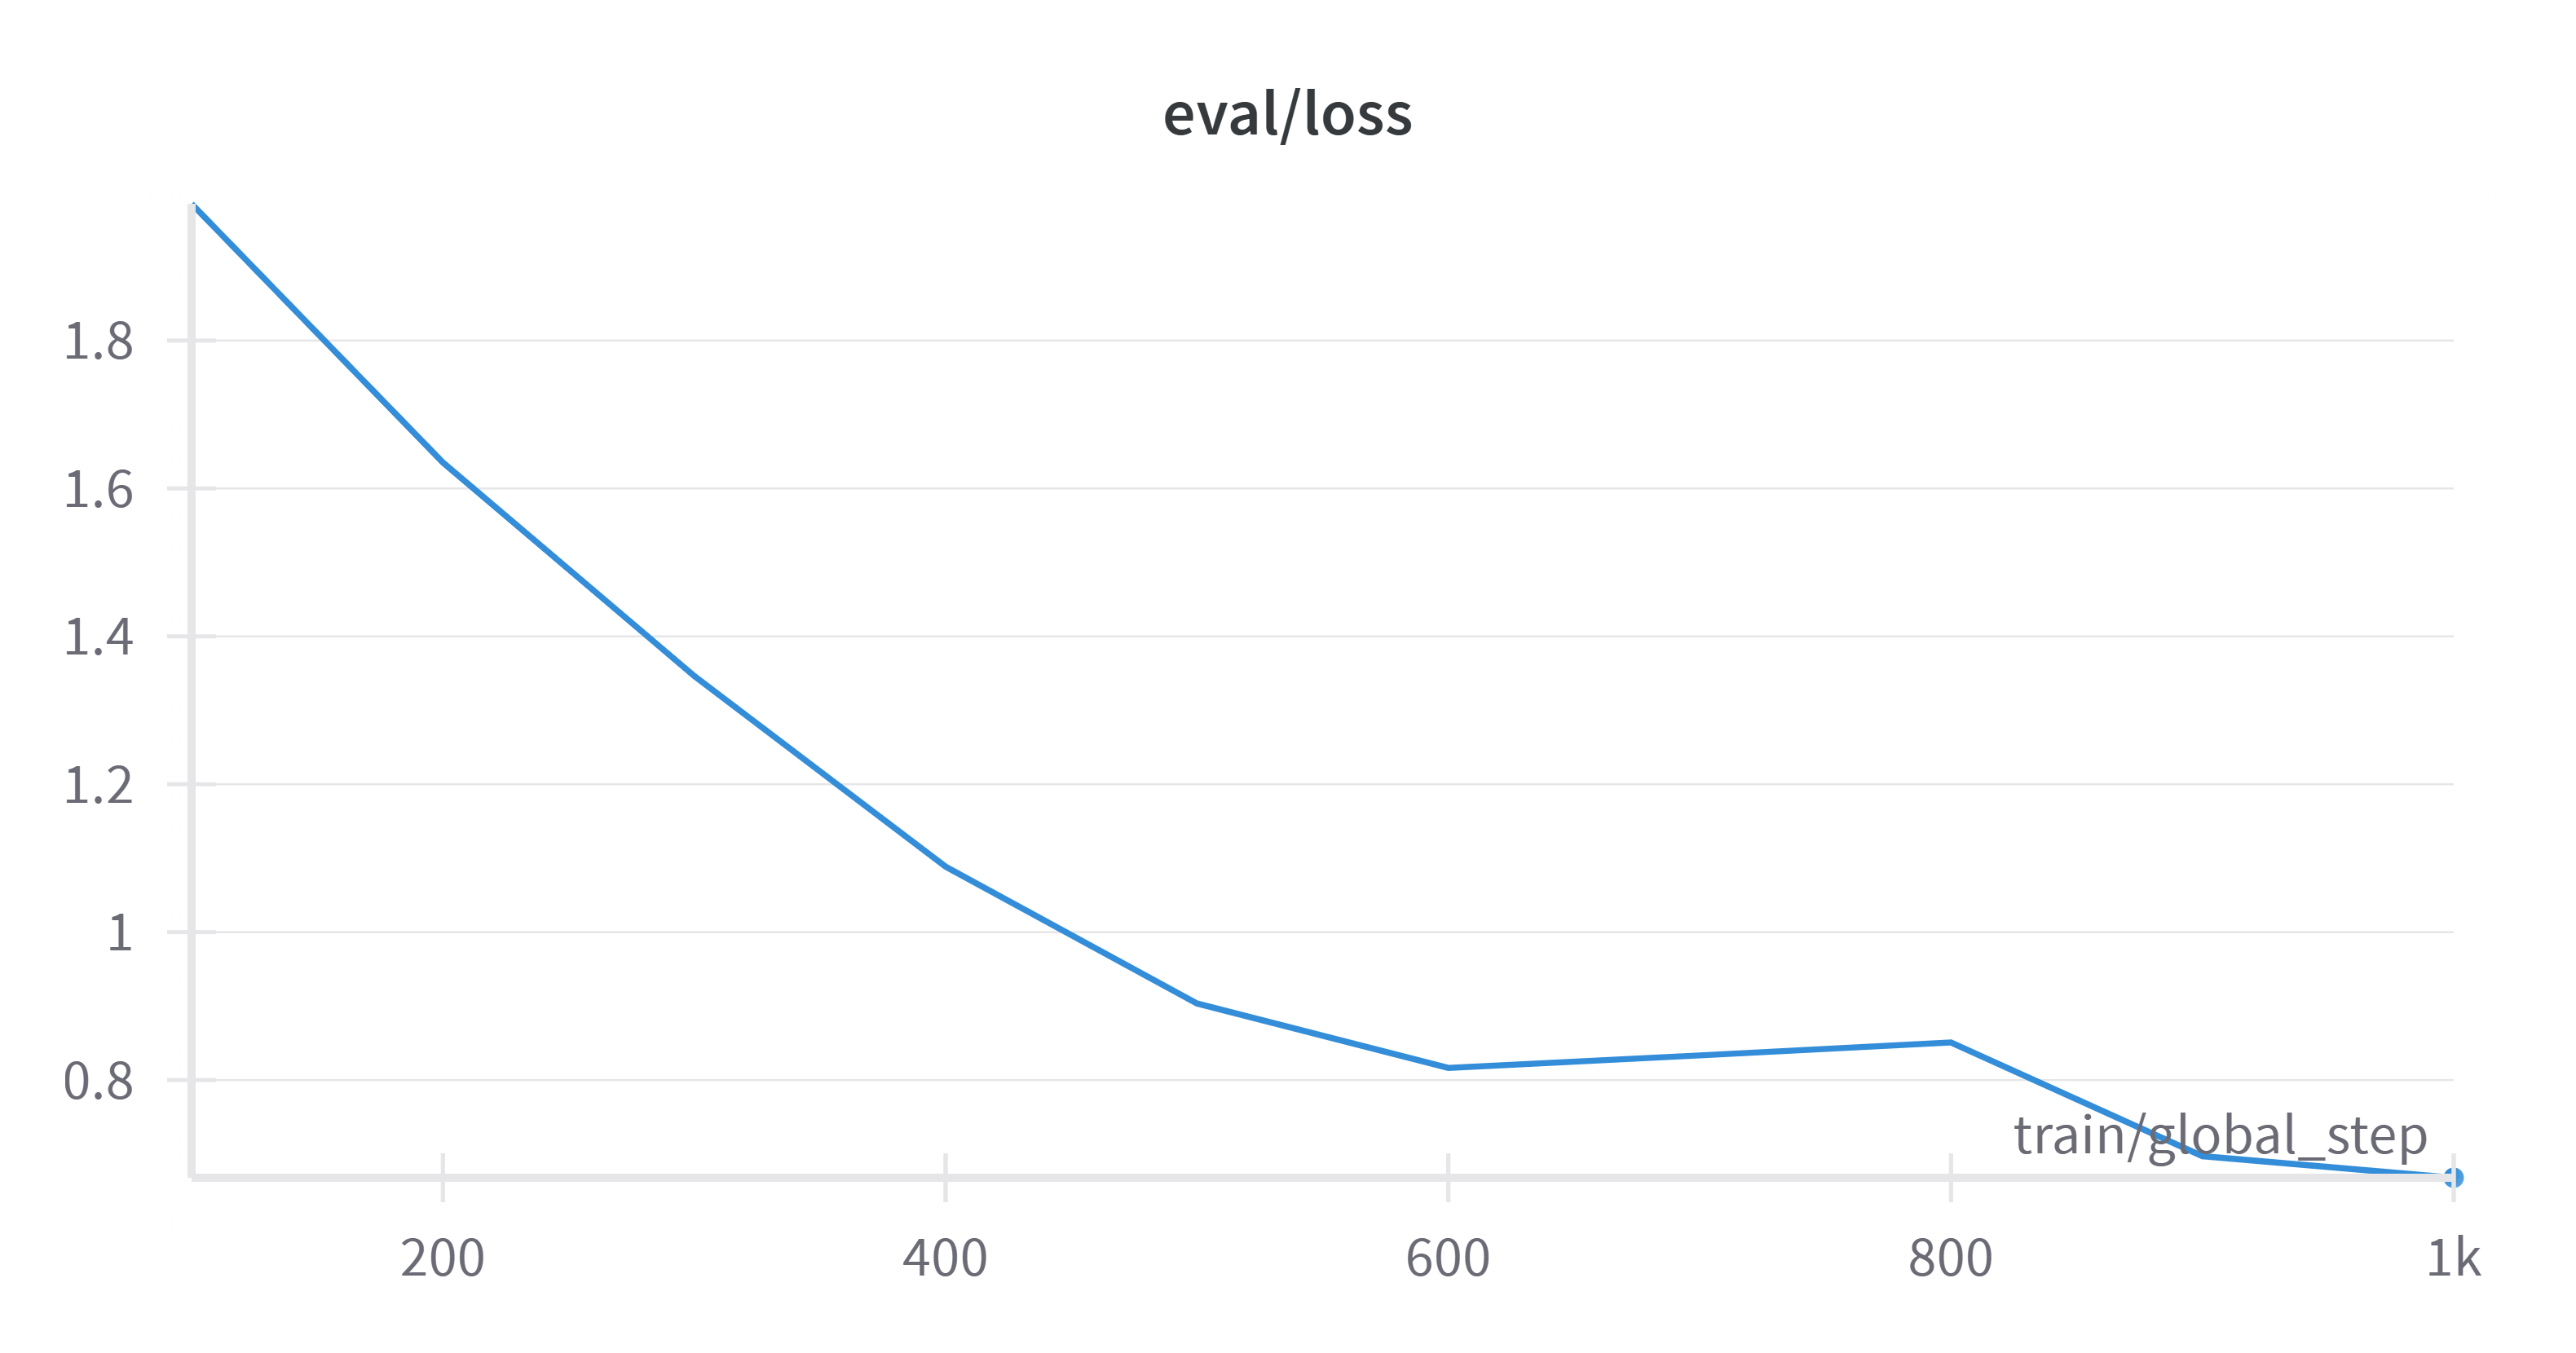

## Conclusion
- We learned to fine-tune a large pre-trained model to achieve reasonably good performance on audio classification task.
- It's amazing to see how the approach for finetuning for audio task is quite similar to that of finetuning across other modalities.
- We noticed that our model suffered from overfitting. Here are some of the approaches that can be used to mitigate overfitting and achieve accuracy beyond 83%:
  - **Data Augmentation:** Number of training examples can be increased by using data augmentation. A library like `audiomentations` can be used for this purpose.
  - **Regularization:** L1 or L2 regularization can be used to reduce overfitting.
  - **Use Smaller Model:** Since the model we have used is quite big, using a smaller model might be a great idea considering the simple nature of the classificatio task.
  - **Fine-tune few layers:** In the above example, we fine-tuned the entire model (all parameters of the model). However, only finetuning last layers or only a few attention heads will help to reduce overfitting. This will also help to speed up training and will consume less resources.

## References
1. [Dataset](https://huggingface.co/datasets/marsyas/gtzan)
2. [Model](https://huggingface.co/facebook/wav2vec2-base) 